In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("stage1_optical_properties.csv")

In [3]:
df.columns

Index(['Unnamed: 0', 'site', 'date', 'time', 'aod_440', 'aod_675', 'aod_870',
       'aod_1020', 'eae_440_870', 'ssa_440', 'ssa_675', 'ssa_870', 'ssa_1020',
       'g_440', 'g_675', 'g_870', 'g_1020', 'ri_real_440', 'ri_real_675',
       'ri_real_870', 'ri_real_1020', 'ri_imag_440', 'ri_imag_675',
       'ri_imag_870', 'ri_imag_1020', 'REff-F', 'Std-F', 'REff-C', 'Std-C',
       'REff-F^2', 'REff-C^2', 'Std-F^2', 'Std-C^2', 'Vol-Con_Fine',
       'Vol-Con_Coarse', 'gamma', 'latitude', 'longitude', 'datetime',
       'Solar_Zenith_Angle', 'aerosol_type', 'AAE_440_870',
       'aerosol_type_refined'],
      dtype='object')

In [4]:
microphysics_stats = df.groupby('aerosol_type').agg({
    'ri_real_440': 'mean',
    'ri_imag_440': 'mean',
    'gamma' : 'mean',
    'REff-F': 'mean',  
    'REff-C': 'mean',
    'Std-F': 'mean',
    'Std-C': 'mean',
    
}).reset_index()


microphysics_stats

,aerosol_type,ri_real_440,ri_imag_440,gamma,REff-F,REff-C,Std-F,Std-C
0,Biomass Burning,1.480173,0.014684,0.693228,0.151470,2.595327,0.420803,0.650520
1,Dust,1.465163,0.003535,7.413699,0.122431,1.757396,0.684092,0.546988
2,Mixed-Coarse,1.465861,0.005461,6.314375,0.119982,1.889601,0.583975,0.581030
3,Mixed-Fine,1.481535,0.012563,1.614495,0.162210,2.366835,0.466944,0.635312
4,Urban/Industrial,1.444897,0.006220,0.572191,0.175900,2.492560,0.445845,0.640092


In [5]:
pip install PyMieScatt numpy pandas matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [6]:
import numpy as np

def bimodal_lognormal_distribution(r, rg1, rg2, sigma1, sigma2, gamma, constant=1.0):
    
    fine_mode = np.exp(-(np.log(r) - np.log(rg1))**2 / (2 * np.log(sigma1)**2))
    
    coarse_mode = gamma * np.exp(-(np.log(r) - np.log(rg2))**2 / (2 * np.log(sigma2)**2))
    
    n_r = constant * (r**(-4)) * (fine_mode + coarse_mode)
    
    return n_r


In [7]:
from PyMieScatt import MieQ

params = {
    'Dust': {
        'm': 1.46145 + 0.003535j,  # CRI from Table 4
        'rg1': 0.122431, 'rg2': 1.757396,  # Fine/coarse radii (Table 3)
        'sigma1': 0.684092, 'sigma2': 0.546988,  # SD from Table 3
        'gamma': 7.413699
        
    },
    'Urban/Industrial': {
        'm': 1.444897 + 0.006220j,
        'rg1': 0.175900, 'rg2': 2.492560,
        'sigma1': 0.445845, 'sigma2': 0.640092,
        'gamma': 0.572191
    },
    'Biomass Burning': {
        'm': 1.480173 + 0.014684j,
        'rg1': 0.151470, 'rg2': 2.595327,
        'sigma1': 0.420803, 'sigma2': 0.650520,
        'gamma': 0.693228
    },
    'Mixed-Coarse': {
        'm': 1.465861 + 0.005461j,
        'rg1': 0.119982, 'rg2': 1.889601,
        'sigma1': 0.583975, 'sigma2': 0.581030,
        'gamma': 6.314375
    },
    'Mixed-Fine': {
        'm': 1.481535 + 0.012563j,
        'rg1': 0.157, 'rg2': 2.3310,
        'sigma1': 0.466944, 'sigma2': 0.635312,
        'gamma': 1.614495
    },
}


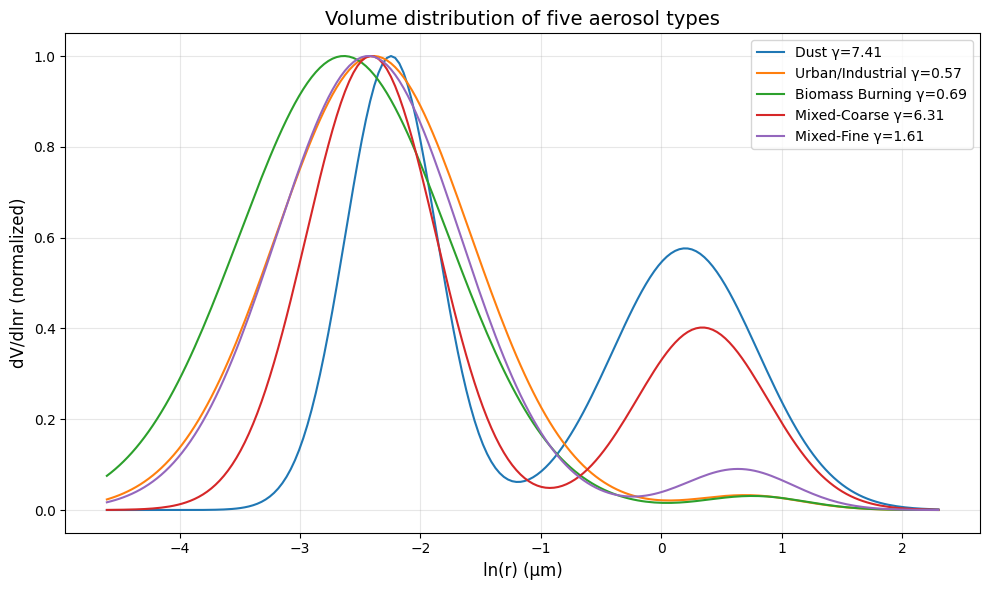

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate radius array for plotting (logarithmically spaced)
radii = np.logspace(-2, 1, 200)  # 0.01 to 10 micrometers

# Calculate volume distribution for each aerosol type
plt.figure(figsize=(10, 6))

for aerosol_type, p in params.items():
    # Calculate number distribution using the provided function
    n_r = bimodal_lognormal_distribution(
        radii, 
        p['rg1'], 
        p['rg2'], 
        p['sigma1'], 
        p['sigma2'], 
        p['gamma']
    )
    
    # Convert to volume distribution (multiply by particle volume)
    volume_dist = n_r * (4/3) * np.pi * (radii**3)
    
    # Normalize for better visualization
    volume_dist_normalized = volume_dist / np.max(volume_dist)
    
    # Plot on logarithmic x-axis
    plt.plot(np.log(radii), volume_dist_normalized, 
             label=f"{aerosol_type} γ={p['gamma']:.2f}")

# Styling to match the figure in the paper
plt.xlabel('ln(r) (μm)', fontsize=12)
plt.ylabel('dV/dlnr (normalized)', fontsize=12)
plt.title('Volume distribution of five aerosol types', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('aerosol_volume_distribution.png', dpi=300)
plt.show()


In [12]:
def calculate_extinction_coefficient(r, n_r, C_ext):
   
    from scipy.integrate import trapz
    
    # Multiply the extinction cross-section by the size distribution
    integrand = C_ext * n_r
    
    # Perform numerical integration using trapezoid rule
    beta_e = trapz(integrand, r)
    
    return beta_e


In [13]:
def calculate_EAE(aod_440, aod_870):
    import numpy as np
    
    # Calculate EAE using the formula
    EAE = -(np.log(aod_440 / aod_870)) / (np.log(440 / 870))
    
    return EAE


In [14]:
def calculate_SSA(tau_s, tau_e):

    # SSA is simply the ratio of scattering to extinction
    SSA = tau_s / tau_e
    
    return SSA


In [15]:
def calculate_asymmetry_parameter(cos_theta, phase_function):
    from scipy.integrate import trapz
    
    # Calculate integrand: p(cos θ) * cos θ
    integrand = phase_function * cos_theta
    
    # Perform numerical integration and multiply by 0.5
    g = 0.5 * trapz(integrand, cos_theta)
    
    return g


In [16]:
r =np.array([
    0.05, 0.065604, 0.086077, 0.112939, 0.148184, 
    0.194429, 0.255105, 0.334716, 0.439173, 0.576227,
    0.756052, 0.991996, 1.301571, 1.707757, 2.240702,
    2.939966, 3.857452, 5.06126, 6.640745, 8.713145, 
    11.432287, 15.0
])

from PyMieScatt import MieQ

def calculate_C_ext(r, wavelength, refractive_index):
    C_ext = []
    for radius in r:
        # Calculate Mie parameters (convert radius μm → diameter nm)
        qext, _, _, _, _, _, _ = MieQ(
            m=refractive_index,  # From your params dictionary
            wavelength=wavelength,  # e.g., 440 nm
            diameter=2 * radius * 1000  # Convert μm to nm
        )
        # Cross-section = efficiency × geometric cross-section
        c_ext = qext * np.pi * (radius**2)
        C_ext.append(c_ext)
    return np.array(C_ext)

def calculate_all_extinction_coefficients(r, params, wavelengths):
 
    results = {}
    
    for aerosol_type in params.keys():
        results[aerosol_type] = {}
        
        # Get refractive index for this aerosol type
        m = params[aerosol_type]['m']
        
        # Calculate bimodal lognormal distribution for this aerosol type
        n_r = bimodal_lognormal_distribution(
            r, 
            params[aerosol_type]['rg1'],
            params[aerosol_type]['rg2'],
            params[aerosol_type]['sigma1'],
            params[aerosol_type]['sigma2'],
            params[aerosol_type]['gamma']
        )
        
        for wl in wavelengths:
            # Calculate extinction cross-section
            C_ext = calculate_C_ext(r, wl, m)
            
            # Calculate extinction coefficient
            beta_e = calculate_extinction_coefficient(r, n_r, C_ext)
            
            # Store result
            results[aerosol_type][wl] = beta_e
    
    return results

wavelengths = [440, 675, 870, 1020]  # nm

# Calculate extinction coefficients for all aerosol types and wavelengths
extinction_coeffs = calculate_all_extinction_coefficients(r, params, wavelengths)
for aerosol_type in params.keys():
    print(f"\n{aerosol_type} extinction coefficients:")
    for wl in wavelengths:
        print(f"  {wl} nm: {extinction_coeffs[aerosol_type][wl]:.4f}")


C:\Users\Namrata\AppData\Local\Temp\ipykernel_18128\2163660644.py:9: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  beta_e = trapz(integrand, r)



Dust extinction coefficients:
  440 nm: 84.2474
  675 nm: 70.1197
  870 nm: 67.5015
  1020 nm: 69.6574

Urban/Industrial extinction coefficients:
  440 nm: 55.0186
  675 nm: 30.2755
  870 nm: 20.1534
  1020 nm: 15.6806

Biomass Burning extinction coefficients:
  440 nm: 59.6203
  675 nm: 32.4599
  870 nm: 21.8630
  1020 nm: 17.1574

Mixed-Coarse extinction coefficients:
  440 nm: 75.0300
  675 nm: 53.9220
  870 nm: 49.2086
  1020 nm: 49.3336

Mixed-Fine extinction coefficients:
  440 nm: 61.2667
  675 nm: 34.4485
  870 nm: 24.2731
  1020 nm: 19.8788


In [18]:
wavelengths = [440, 675, 870, 1020]  # nm
def calculate_all_normalized_aod(extinction_coeffs , wavelengths):

    z = np.linspace(0, 15, 50)  # 0-15 km, 50 points
    
    H = 2.0  # Scale height in km
    N_z = np.exp(-z/H)
    
    normalized_aod_all = {}
    for aerosol_type in extinction_coeffs.keys():
       
        aod_values = {}
        
        for wl in wavelengths:
            beta_ext = extinction_coeffs[aerosol_type][wl]
            
            integrand = beta_ext * N_z
            aod = np.trapz(integrand, z)
            aod_values[wl] = aod
        
        aod_440 = aod_values[440]
        normalized_aod = {wl: aod_values[wl]/aod_440 for wl in wavelengths}
        
        normalized_aod_all[aerosol_type] = normalized_aod
    
    return normalized_aod_all

normalized_aod_all = calculate_all_normalized_aod(extinction_coeffs, wavelengths)

normalized_aod_df = []
for aerosol_type, aod_dict in normalized_aod_all.items():
    for wl, aod in aod_dict.items():
        normalized_aod_df.append({
            'aerosol_type': aerosol_type,
            'wavelength': wl,
            'normalized_aod': aod
        })

normalized_aod_df = pd.DataFrame(normalized_aod_df)
normalized_aod_df

,aerosol_type,wavelength,normalized_aod
0,Dust,440,1.000000
1,Dust,675,0.832307
2,Dust,870,0.801230
3,Dust,1020,0.826820
4,Urban/Industrial,440,1.000000
5,Urban/Industrial,675,0.550278
6,Urban/Industrial,870,0.366300
7,Urban/Industrial,1020,0.285005
8,Biomass Burning,440,1.000000
9,Biomass Burning,675,0.544444


In [21]:
def get_aod_440_870(extinction_coeffs):
    z = np.linspace(0, 15, 50)  
    H = 2.0  
    N_z = np.exp(-z/H)
    
    # Initialize results dictionary
    results = {}
    
    for aerosol_type in extinction_coeffs.keys():
        beta_ext_440 = extinction_coeffs[aerosol_type][440]
        aod_440 = np.trapz(beta_ext_440 * N_z, z)
        
        # Calculate AOD at 870 nm
        beta_ext_870 = extinction_coeffs[aerosol_type][870]
        aod_870 = np.trapz(beta_ext_870 * N_z, z)
        
        results[aerosol_type] = {'aod_440': aod_440, 'aod_870': aod_870}
    
    return results

# Use this function to get the original AODs
original_aods = get_aod_440_870(extinction_coeffs)

original_aods

{'Dust': {'aod_440': 168.73018576553318, 'aod_870': 135.1916655978592},
 'Urban/Industrial': {'aod_440': 110.19103571981717,
  'aod_870': 40.36302831601283},
 'Biomass Burning': {'aod_440': 119.40725631327335,
  'aod_870': 43.78706445847724},
 'Mixed-Coarse': {'aod_440': 150.26973554600298, 'aod_870': 98.55466159189157},
 'Mixed-Fine': {'aod_440': 122.7046503576234, 'aod_870': 48.61409152315165}}

In [41]:
import numpy as np

eae_results = {}

for aerosol_type, aod_values in original_aods.items():
    eae = calculate_EAE(aod_values['aod_440'], aod_values['aod_870'])
    eae_results[aerosol_type] = eae

eae_results

eae_df = pd.DataFrame([
    {'aerosol_type': k, 'EAE': v}
    for k, v in eae_results.items()
])

eae_df

,aerosol_type,EAE
0,Dust,0.325072
1,Urban/Industrial,1.473191
2,Biomass Burning,1.471577
3,Mixed-Coarse,0.618761
4,Mixed-Fine,1.358137


In [24]:
def calculate_C_sca(r, wavelength, refractive_index):
    C_sca = []
    for radius in r:
        # Calculate Mie parameters (convert radius μm → diameter nm)
        # The second return value from MieQ is qsca (scattering efficiency)
        _, qsca, _, _, _, _, _ = MieQ(
            m=refractive_index,
            wavelength=wavelength,
            diameter=2 * radius * 1000  # Convert μm to nm
        )
        # Cross-section = efficiency × geometric cross-section
        c_sca = qsca * np.pi * (radius**2)
        C_sca.append(c_sca)
    return np.array(C_sca)

def calculate_scattering_coefficient(r, n_r, C_sca):
  
    from scipy.integrate import trapz
    
    # Multiply the scattering cross-section by the size distribution
    integrand = C_sca * n_r
    
    # Perform numerical integration using trapezoid rule
    beta_s = trapz(integrand, r)
    
    return beta_s

def calculate_all_scattering_coefficients(r, params, wavelengths):
    results = {}
    
    for aerosol_type in params.keys():
        results[aerosol_type] = {}
        
        # Get refractive index for this aerosol type
        m = params[aerosol_type]['m']
        
        # Calculate bimodal lognormal distribution for this aerosol type
        n_r = bimodal_lognormal_distribution(
            r, 
            params[aerosol_type]['rg1'],
            params[aerosol_type]['rg2'],
            params[aerosol_type]['sigma1'],
            params[aerosol_type]['sigma2'],
            params[aerosol_type]['gamma']
        )
        
        for wl in wavelengths:
            # Calculate scattering cross-section
            C_sca = calculate_C_sca(r, wl, m)
            
            # Calculate scattering coefficient
            beta_s = calculate_scattering_coefficient(r, n_r, C_sca)
            
            # Store result
            results[aerosol_type][wl] = beta_s
    
    return results

# Calculate scattering coefficients for all aerosol types and wavelengths
scattering_coeffs = calculate_all_scattering_coefficients(r, params, wavelengths)

for aerosol_type in params.keys():
    print(f"\n{aerosol_type} scattering coefficients:")
    for wl in wavelengths:
        print(f"  {wl} nm: {scattering_coeffs[aerosol_type][wl]:.4f}")


C:\Users\Namrata\AppData\Local\Temp\ipykernel_18128\26624345.py:24: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  beta_s = trapz(integrand, r)



Dust scattering coefficients:
  440 nm: 77.1408
  675 nm: 64.6843
  870 nm: 63.4047
  1020 nm: 65.9560

Urban/Industrial scattering coefficients:
  440 nm: 52.3178
  675 nm: 28.6038
  870 nm: 18.8962
  1020 nm: 14.6178

Biomass Burning scattering coefficients:
  440 nm: 53.6563
  675 nm: 28.7147
  870 nm: 19.0036
  1020 nm: 14.7337

Mixed-Coarse scattering coefficients:
  440 nm: 67.0238
  675 nm: 47.9479
  870 nm: 44.3642
  1020 nm: 45.0217

Mixed-Fine scattering coefficients:
  440 nm: 55.0557
  675 nm: 30.2859
  870 nm: 20.9467
  1020 nm: 16.9775


In [29]:
def calculate_all_scattering_aod(scattering_coeffs, wavelengths):
    
    z = np.linspace(0, 15, 50)  # 0-15 km, 50 points
    
    H = 2.0  # Scale height in km
    N_z = np.exp(-z/H)
    
    scattering_aod_all = {}
    for aerosol_type in scattering_coeffs.keys():
       
        scattering_aod_values = {}
        
        for wl in wavelengths:
            beta_sca = scattering_coeffs[aerosol_type][wl]
            
            # Calculate original scattering optical depth
            integrand = beta_sca * N_z
            scattering_aod = np.trapz(integrand, z)
            scattering_aod_values[wl] = scattering_aod
        
        # Store original (non-normalized) values
        scattering_aod_all[aerosol_type] = scattering_aod_values
    
    return scattering_aod_all

# Calculate original scattering optical depth
original_scattering_aod_all = calculate_all_scattering_aod(scattering_coeffs, wavelengths)

# Create DataFrame with original values
scattering_aod_df = []
for aerosol_type, aod_dict in original_scattering_aod_all.items():
    for wl, aod in aod_dict.items():
        scattering_aod_df.append({
            'aerosol_type': aerosol_type,
            'wavelength': wl,
            'original_scattering_aod': aod
        })

scattering_aod_df = pd.DataFrame(scattering_aod_df)
scattering_aod_df


,aerosol_type,wavelength,original_scattering_aod
0,Dust,440,154.497259
1,Dust,675,129.549372
2,Dust,870,126.986686
3,Dust,1020,132.096249
4,Urban/Industrial,440,104.781787
5,Urban/Industrial,675,57.287633
6,Urban/Industrial,870,37.845259
7,Urban/Industrial,1020,29.276384
8,Biomass Burning,440,107.462492
9,Biomass Burning,675,57.509659


In [31]:
def get_all_original_aods(extinction_coeffs, wavelengths=[440, 675, 870, 1020]):
    z = np.linspace(0, 15, 50)  # 0-15 km, 50 points
    H = 2.0  # Scale height in km
    N_z = np.exp(-z/H)
    
    # Initialize results dictionary
    results = {}
    
    for aerosol_type in extinction_coeffs.keys():
        aod_values = {}
        
        # Calculate AOD for each wavelength
        for wl in wavelengths:
            beta_ext = extinction_coeffs[aerosol_type][wl]
            aod = np.trapz(beta_ext * N_z, z)
            aod_values[wl] = aod
        
        # Store all AOD values for this aerosol type
        results[aerosol_type] = aod_values
    
    return results

# Use this function to get the original AODs for all wavelengths
original_aods_all = get_all_original_aods(extinction_coeffs)

original_aod_df = []
for aerosol_type, aod_dict in original_aods_all.items():
    for wl, aod in aod_dict.items():
        original_aod_df.append({
            'aerosol_type': aerosol_type,
            'wavelength': wl,
            'original_extinction_aod': aod
        })

original_aod_df = pd.DataFrame(original_aod_df)
original_aod_df


,aerosol_type,wavelength,original_extinction_aod
0,Dust,440,168.730186
1,Dust,675,140.435379
2,Dust,870,135.191666
3,Dust,1020,139.509475
4,Urban/Industrial,440,110.191036
5,Urban/Industrial,675,60.635668
6,Urban/Industrial,870,40.363028
7,Urban/Industrial,1020,31.404962
8,Biomass Burning,440,119.407256
9,Biomass Burning,675,65.010579


In [35]:
def calculate_all_SSA(scattering_data, extinction_data):
  
    ssa_results = []
    
    for i in range(len(scattering_data)):
        aerosol_type = scattering_data.iloc[i]['aerosol_type']
        wavelength = scattering_data.iloc[i]['wavelength']
        tau_s = scattering_data.iloc[i]['original_scattering_aod']
        tau_e = extinction_data.iloc[i]['original_extinction_aod']
        
        # Calculate SSA using your function
        ssa = calculate_SSA(tau_s, tau_e)
        
        # Store result
        ssa_results.append({
            'aerosol_type': aerosol_type,
            'wavelength': wavelength,
            'SSA': ssa
        })
    
    # Convert to DataFrame
    ssa_df = pd.DataFrame(ssa_results)
    
    return ssa_df
ssa_df = calculate_all_SSA(scattering_aod_df, original_aod_df)
ssa_df

,aerosol_type,wavelength,SSA
0,Dust,440,0.915647
1,Dust,675,0.922484
2,Dust,870,0.939309
3,Dust,1020,0.946862
4,Urban/Industrial,440,0.950910
5,Urban/Industrial,675,0.944784
6,Urban/Industrial,870,0.937622
7,Urban/Industrial,1020,0.932222
8,Biomass Burning,440,0.899966
9,Biomass Burning,675,0.884620


In [39]:
def calculate_g_for_aerosol_types(params, wavelengths):

    g_values = {}
    
    for aerosol_type in params.keys():
        g_values[aerosol_type] = {}
        
        # Get parameters for this aerosol type
        p = params[aerosol_type]
        m = p['m']  # Complex refractive index
        
        # Create radius grid for integration (fine enough to capture both modes)
        r = np.logspace(-2, 1.5, 200)  # 0.01 to 31.6 µm
        
        # Calculate size distribution
        n_r = bimodal_lognormal_distribution(
            r, p['rg1'], p['rg2'], p['sigma1'], p['sigma2'], p['gamma']
        )
        
        for wl in wavelengths:
            # Calculate weighted g values across all particle sizes
            g_weighted_sum = 0
            weight_sum = 0
            
            for i, radius in enumerate(r):
                if n_r[i] > 0:
                    # Get Mie parameters including g (4th return value)
                    _, qsca, _, g, _, _, _ = MieQ(
                        m=m, 
                        wavelength=wl, 
                        diameter=2*radius*1000  # Convert µm to nm
                    )
                    
                    # Weight by scattering cross-section
                    weight = n_r[i] * qsca * np.pi * (radius**2)
                    g_weighted_sum += g * weight
                    weight_sum += weight
            
            # Calculate weighted average g
            g_avg = g_weighted_sum / weight_sum if weight_sum > 0 else 0
            g_values[aerosol_type][wl] = g_avg
    
    return g_values
g_values =  calculate_g_for_aerosol_types(params, wavelengths)
def g_dict_to_df(g_values):
    rows = []
    for aerosol_type, wl_dict in g_values.items():
        for wavelength, g in wl_dict.items():
            rows.append({
                'aerosol_type': aerosol_type,
                'wavelength': wavelength,
                'g': g
            })
    return pd.DataFrame(rows)

# Example usage:
g_df = g_dict_to_df(g_values)
g_df


,aerosol_type,wavelength,g
0,Dust,440,0.608848
1,Dust,675,0.564840
2,Dust,870,0.599083
3,Dust,1020,0.632335
4,Urban/Industrial,440,0.617074
5,Urban/Industrial,675,0.553758
6,Urban/Industrial,870,0.510889
7,Urban/Industrial,1020,0.483207
8,Biomass Burning,440,0.582620
9,Biomass Burning,675,0.522931


In [42]:
import pandas as pd

# First merge the dataframes that contain wavelength information
merged_df = pd.merge(ssa_df, normalized_aod_df, on=['aerosol_type', 'wavelength'])
merged_df = pd.merge(merged_df, g_df, on=['aerosol_type', 'wavelength'])

# Then add the EAE values (which don't vary by wavelength)
final_df = pd.merge(merged_df, eae_df, on='aerosol_type')

# Reorder columns for better organization
final_df = final_df[['aerosol_type', 'wavelength', 'normalized_aod', 'SSA', 'g', 'EAE']]

# Save to CSV
final_df.to_csv('aerosol_optical_database.csv', index=False)

# Display a preview of the final merged dataset
print(final_df.head())


       aerosol_type  wavelength  normalized_aod       SSA         g       EAE
0              Dust         440        1.000000  0.915647  0.608848  0.325072
1              Dust         675        0.832307  0.922484  0.564840  0.325072
2              Dust         870        0.801230  0.939309  0.599083  0.325072
3              Dust        1020        0.826820  0.946862  0.632335  0.325072
4  Urban/Industrial         440        1.000000  0.950910  0.617074  1.473191
